In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
# show plots automatically
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy import stats


## Data Loading

In [5]:
df = pd.read_csv('./HelocData.csv', na_values = [-7, -8, -9])

#Delete rows with no record(-9)
df = df[df.sum(axis=1) != 0]

print(df.shape)
df.head()


(9871, 24)


,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,Bad,75.0,169.0,2.0,59.0,21.0,0.0,0.0,100.0,NaN,...,36.0,NaN,4.0,4.0,43.0,112.0,4.0,6.0,0.0,83.0
1,Bad,66.0,502.0,4.0,145.0,34.0,0.0,0.0,97.0,36.0,...,27.0,4.0,3.0,3.0,80.0,53.0,17.0,3.0,12.0,83.0
2,Good,69.0,338.0,2.0,62.0,22.0,0.0,0.0,96.0,12.0,...,35.0,0.0,4.0,4.0,25.0,100.0,3.0,2.0,1.0,45.0
3,Good,75.0,422.0,1.0,91.0,55.0,0.0,0.0,100.0,NaN,...,33.0,0.0,4.0,4.0,2.0,11.0,12.0,2.0,1.0,57.0
4,Bad,63.0,242.0,2.0,68.0,25.0,0.0,0.0,100.0,NaN,...,19.0,NaN,3.0,3.0,73.0,NaN,12.0,1.0,5.0,87.0


In [6]:
data_dict = pd.read_excel('./HelocDataDict.xlsx', index_col=0, squeeze=True)

var_names = data_dict.str.split('(\.| \()', expand = True).iloc[1:,0]
var_names.name = 'Description'
var_names.to_frame()

,Description
Variable Names,
x1,Consolidated version of risk markers
x2,Months Since Oldest Trade Open
x3,Months Since Most Recent Trade Open
x4,Average Months in File
x5,Number Satisfactory Trades
x6,Number Trades 60+ Ever
x7,Number Trades 90+ Ever
x8,Percent Trades Never Delinquent
x9,Months Since Most Recent Delinquency


## Data split 

In [11]:
np.random.seed(3612202007)
df_train, df_test = train_test_split(df, test_size=0.2)

train_size = df_train.shape[0]/df.shape[0]
test_size = df_test.shape[0]/df.shape[0]
print('Proportion of training set: {:.2%}'.format(train_size),df_train.shape,sep='\t')
print('Proportion of training set: {:.2%}'.format(test_size),df_test.shape,sep='\t')

df_train_beforeimputation = df_train.copy()
df_test_beforeimputation = df_test.copy()

Proportion of training set: 79.99%	(7896, 24)
Proportion of training set: 20.01%	(1975, 24)


## Data Imputation 

In [12]:
def SImputer(df):
    df_imputed = df.copy()
    SI = SimpleImputer(missing_values=np.nan)
    SI.fit(df.iloc[:, 1:])
    df_imputed.iloc[:, 1:] = SI.transform(df.iloc[:, 1:])
    return df_imputed


def IImputer(df):
    df_imputed = df.copy()
    II = IterativeImputer(max_iter=100,missing_values=np.nan)
    II.fit(df.iloc[:, 1:])
    df_imputed.iloc[:, 1:] = II.transform(df.iloc[:, 1:])
    return df_imputed

df_train = SImputer(df_train)
df_test = SImputer(df_test)

## GLM : Logistic Regression (sklearn) 
- full model before feature selection
- l2 Ridge regularization penalty
- newton-cg solver

In [13]:
X_train = df_train.iloc[:, 1:]
y_train = (df_train['RiskFlag'].values == 'Good').astype(np.int)
X_test = df_test.iloc[:, 1:]
y_test = (df_test['RiskFlag'].values == 'Good').astype(np.int)

# coefficients estimated by sklearn
logreg1 = LogisticRegression(penalty='none', solver='newton-cg')
logreg1.fit(X_train, y_train)
#print('Intercept:', *np.round(logreg1.intercept_, 4), '\n'
#      'Coefficients:', *np.round(np.squeeze(logreg1.coef_), 4))  # use * to get each corrdinate inside an array

# penalty = l1
#logreg3 = LogisticRegression(penalty='l1', solver='newton-cg')
#logreg3.fit(X_train, y_train)

# penalty=l2
logreg4 = LogisticRegression(penalty='l2', solver='newton-cg')
logreg4.fit(X_train, y_train)

# penalty=elasticnet
#logreg5 = LogisticRegression(penalty='elasticnet', solver='newton-cg')
#logreg5.fit(X_train, y_train)


# by statsmodel
logreg2 = sm.Logit(y_train, sm.add_constant(X_train))
result = logreg2.fit()
print(result.summary())

#predicion and accuracy measurement
y_train_pred_SI = logreg1.predict(X_train)
y_test_pred_SI = logreg1.predict(X_test)
print('Train Simple_accuracy score: ',accuracy_score(y_train,y_train_pred_SI))
print('Test Simple_accuracy score: ',accuracy_score(y_test,y_test_pred_SI))

#y_pred_SI_3 = logreg3.predict(X_train)
#print('l1_accuracy score: ',accuracy_score(y_train,y_pred_SI_3))

y_train_pred_SI_4 = logreg4.predict(X_train)
y_test_pred_SI_4 = logreg4.predict(X_test)
print('Train l2_accuracy_score: ',accuracy_score(y_train,y_train_pred_SI_4))
print('Test l2_accuracy_score: ',accuracy_score(y_test,y_test_pred_SI_4))

#y_pred_SI_5 = logreg5.predict(X_train)
#print('en_accuracy_score: ',accuracy_score(y_train,y_pred_SI_5))

mse_train = mean_squared_error(y_train,y_train_pred_SI)
mse_test = mean_squared_error(y_test,y_test_pred_SI)
print('Train mse_simple: ',mse_train)
print('Test mse_simple: ',mse_test)
mse_train_l2 = mean_squared_error(y_train,y_train_pred_SI_4)
mse_test_l2 = mean_squared_error(y_test,y_test_pred_SI_4)
print('Train mse_Ridge: ',mse_train_l2)
print('Test mse_Ridge: ',mse_test_l2)

Optimization terminated successfully.
         Current function value: 0.541798
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7896
Model:                          Logit   Df Residuals:                     7872
Method:                           MLE   Df Model:                           23
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:                  0.2171
Time:                        10:32:04   Log-Likelihood:                -4278.0
converged:                       True   LL-Null:                       -5464.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4519      0.463    -13.945      0.000      -7.359      -5.545
x1             0.0475      0.

In [378]:
abs(result.params).sort_values(ascending=False)

const    6.451854
x16      0.477182
x17      0.408216
x22      0.103660
x10      0.067759
x20      0.061273
x15      0.050313
x1       0.047545
x5       0.035155
x6       0.033923
x7       0.028743
x13      0.020871
x8       0.020035
x21      0.012418
x18      0.010691
x11      0.010072
x14      0.008956
x4       0.007589
x9       0.005415
x3       0.003890
x23      0.003436
x19      0.001469
x12      0.001149
x2       0.000861
dtype: float64

In [379]:
result.pvalues.sort_values(ascending=False)

x12      7.654582e-01
x11      6.739175e-01
x7       6.643387e-01
x6       5.545538e-01
x21      5.301990e-01
x19      2.830937e-01
x13      2.677205e-01
x3       1.699001e-01
x23      7.332520e-02
x2       3.367603e-02
x9       9.708423e-03
x10      9.602421e-03
x22      3.122338e-04
x17      2.031266e-04
x20      3.887447e-05
x16      9.809110e-06
x14      4.663598e-06
x8       3.322923e-06
x4       2.407369e-08
x18      7.193252e-11
x5       1.102215e-11
x15      7.608141e-13
x1       5.964452e-14
const    3.370434e-44
dtype: float64

## Feature Engineering

In [14]:
df_miss_num = df_train_beforeimputation.iloc[:,1:].isnull().sum()
df_total_num = df_train_beforeimputation.shape[0]
df_miss_freq = 100*df_miss_num / df_total_num
df_miss = pd.concat([df_miss_num, df_miss_freq],axis=1)
df_miss.columns = ['number','frequency']

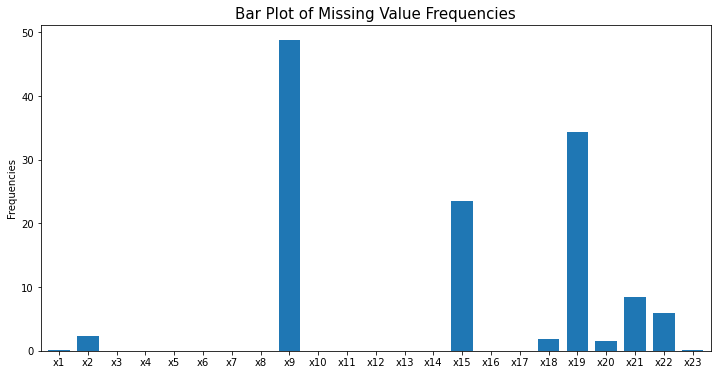

In [15]:
plt.figure(figsize=(12, 6))
df_miss_freq.plot.bar(width=0.75, rot=0, ax=plt.gca())
plt.ylabel('Frequencies')
plt.title('Bar Plot of Missing Value Frequencies', fontsize=15)
plt.show()

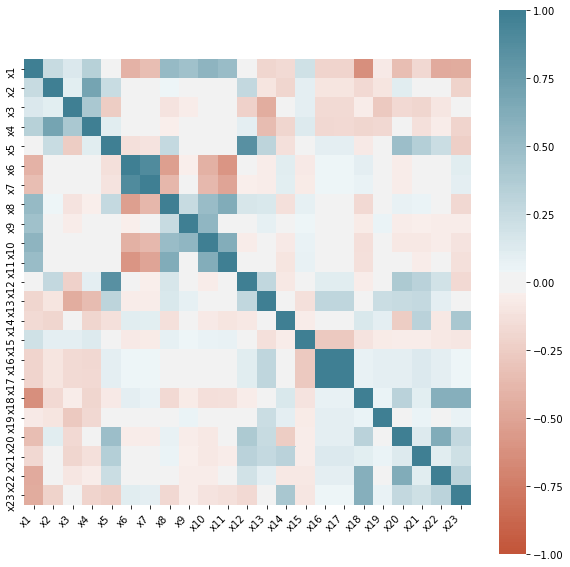

In [16]:
#Correlation Matrix, heatmap
corr = df.iloc[:,1:].corr()

f, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

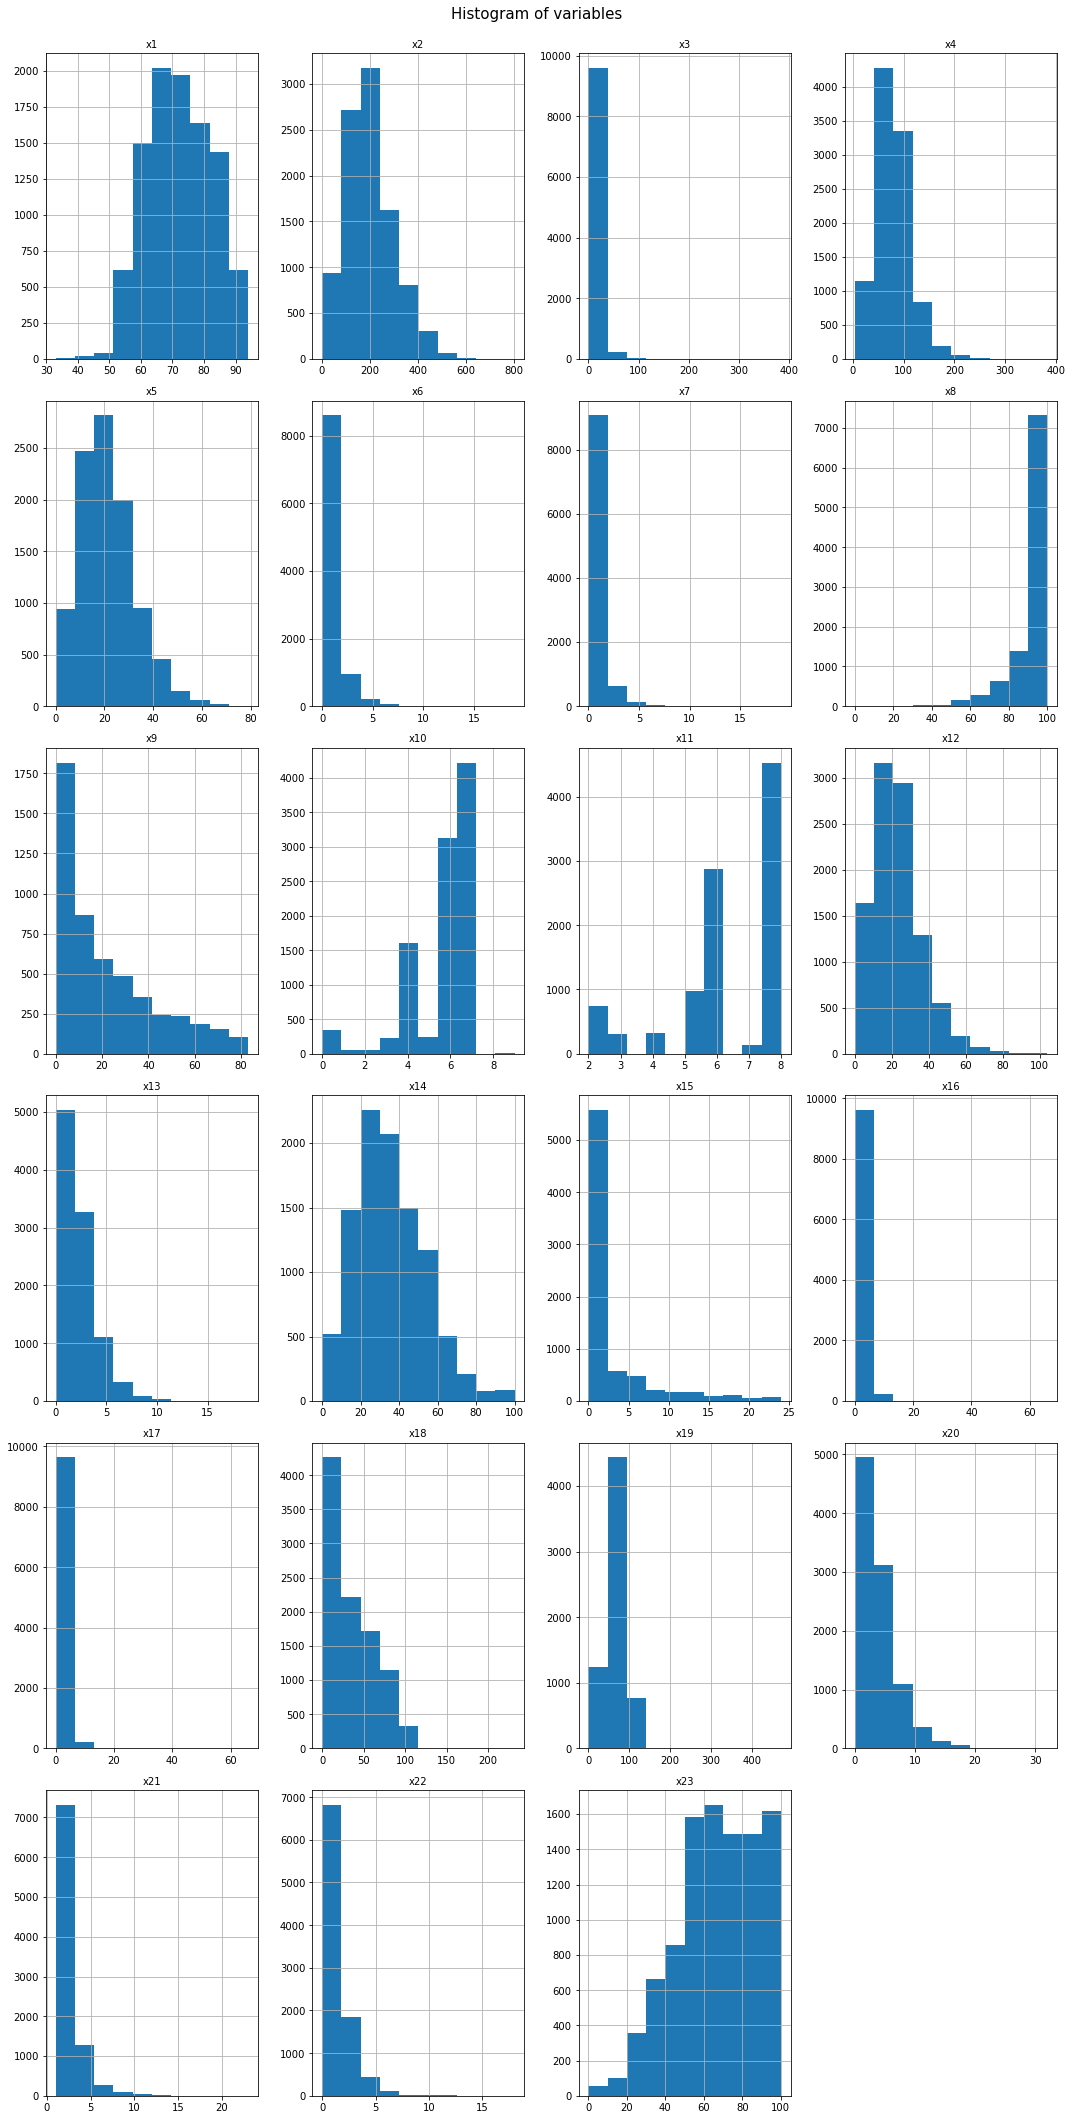

In [17]:
cols = 4  # change `cols` to get other layout
rows = (df.shape[1]-1)//cols + 1  # Floor division

# Figure 1: the boxplot for each feature
fig = plt.figure(figsize=(15, 5*rows))
for i, var_name in enumerate(var_names.index):
    ax = fig.add_subplot(rows,cols,i+1)
    df[var_name].hist()

    ax.set_xlabel('')
    ax.set_title(var_name, fontsize=10)
    
plt.suptitle('Histogram of variables', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # remove extra space
plt.show()

NameError: name 'df_train_final' is not defined

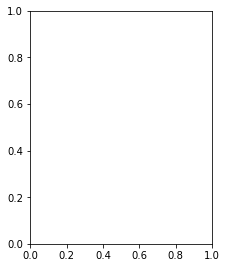

In [18]:
cols = 4  # change `cols` to get other layout
rows = (df.shape[1]-1)//cols + 1  # Floor division

# Figure 1: the boxplot for each feature
fig = plt.figure(figsize=(15, 5*rows))
for i, var_name in enumerate(var_names.index):
    ax = fig.add_subplot(rows,cols,i+1)
    bp = df_train_final.boxplot(column=var_name, by='RiskFlag',
                              ax=ax, return_type='dict')
    [value.set_color('r') for value in bp[0]['medians']] # set median line color
    [value.set_linewidth(2) for value in bp[0]['medians']] # set median linewidth

    ax.set_xlabel('')
    ax.set_ylabel(var_name, rotation=0) # annotate feature names
    ax.set_title(var_name, fontsize=10)
    
plt.suptitle('Box Plot Grouped by RiskFlag', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # remove extra space
plt.show()

### Feature selection

In [19]:
names = ['x1','x2','x4','x5','x8','x10','x11','x12','x13','x14','x15','x16','x18','x20','x22','x23'] # excluded: x3,x6,x7,x9,x17,x19,x21

X_train = df_train[names]
y_train = (df_train['RiskFlag'].values == 'Good').astype(np.int)
X_test = df_test[names]
y_test = (df_test['RiskFlag'].values == 'Good').astype(np.int)

In [20]:
pd.DataFrame(var_names[names])

,Description
Variable Names,
x1,Consolidated version of risk markers
x2,Months Since Oldest Trade Open
x4,Average Months in File
x5,Number Satisfactory Trades
x8,Percent Trades Never Delinquent
x10,Max Delq/Public Records Last 12 Months
x11,Max Delinquency Ever
x12,Number of Total Trades
x13,Number of Trades Open in Last 12 Months


### GLM Logistic Regression with L2 penalty 
- after feature selection

In [383]:
logreg_post_1 = LogisticRegression(penalty='none', solver='newton-cg')
logreg_post_1.fit(X_train, y_train)

logreg_post_2 = sm.Logit(y_train, sm.add_constant(X_train))
result = logreg_post_2.fit()
print(result.summary())

y_train_pred_SI_post_1 = logreg_post_1.predict(X_train)
y_test_pred_SI_post_1 = logreg_post_1.predict(X_test)
print('Train accuracy_score: ',accuracy_score(y_train,y_train_pred_SI_post_1))
print('Test accuracy_score: ',accuracy_score(y_test,y_test_pred_SI_post_1))

Optimization terminated successfully.
         Current function value: 0.543405
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7896
Model:                          Logit   Df Residuals:                     7879
Method:                           MLE   Df Model:                           16
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:                  0.2147
Time:                        10:50:19   Log-Likelihood:                -4290.7
converged:                       True   LL-Null:                       -5464.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7018      0.393    -17.032      0.000      -7.473      -5.931
x1             0.0505      0.

In [384]:
result.pvalues.sort_values(ascending=True)

const    4.761965e-65
x1       5.810743e-17
x15      1.796276e-12
x5       3.877316e-12
x18      3.809973e-10
x4       4.026065e-08
x16      2.761424e-07
x8       5.351308e-07
x14      1.586020e-06
x20      7.567402e-05
x22      2.524434e-04
x10      3.055216e-04
x2       1.762068e-02
x23      8.835568e-02
x13      4.586327e-01
x11      4.659170e-01
x12      8.458403e-01
dtype: float64

In [385]:
result.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
             chi2        P>chi2  df constraint
const  290.086145  4.761965e-65              1
x1      70.040223  5.810743e-17              1
x2       5.633474  1.762068e-02              1
x4      30.136856  4.026065e-08              1
x5      48.185568  3.877316e-12              1
x8      25.132863  5.351308e-07              1
x10     13.036235  3.055216e-04              1
x11      0.531643  4.659170e-01              1
x12      0.037802  8.458403e-01              1
x13      0.549229  4.586327e-01              1
x14     23.040771  1.586020e-06              1
x15     49.694732  1.796276e-12              1
x16     26.409755  2.761424e-07              1
x18     39.207891  3.809973e-10              1
x20     15.663412  7.567402e-05              1
x22     13.393904  2.524434e-04              1
x23      2.904080  8.835568e-02              1

In [386]:
#with Ridge penalty
logreg_post = LogisticRegression(penalty='l2', solver='newton-cg')
logreg_post.fit(X_train, y_train)

y_train_pred_SI_post = logreg_post.predict(X_train)
y_test_pred_SI_post = logreg_post.predict(X_test)
print('Train l2_accuracy_score: ',accuracy_score(y_train,y_train_pred_SI_post))
print('Test l2_accuracy_score: ',accuracy_score(y_test,y_test_pred_SI_post))

Train l2_accuracy_score:  0.7325227963525835
Test l2_accuracy_score:  0.7377215189873417


In [387]:
logreg_post.intercept_[0]

-6.702119251810889

In [388]:
GLM_coef = pd.DataFrame(data={'var':np.transpose(names),'coef':list(logreg_post.coef_[0])}).set_index('var')
GLM_coef.loc['intercept'] = logreg_post.intercept_[0]
GLM_coef.sort_values(by='var',ascending=False)

,coef
var,
x8,0.020424
x5,0.034488
x4,0.007062
x23,0.003204
x22,-0.104724
x20,-0.058218
x2,0.000949
x18,-0.010097
x16,-0.079105


## GAM 

In [21]:
df_train.iloc[:,10].loc[df_train.iloc[:,10] == 6] = 5
df_train.iloc[:,10].loc[df_train.iloc[:,10] == 9] = 8
df_train.iloc[:,10] = df_train.iloc[:,10].astype(int)
df_train.iloc[:,11] = df_train.iloc[:,11].astype(int)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
#!pip install -U pygam

In [23]:
from pygam import LogisticGAM, s, f

gam = LogisticGAM().gridsearch(np.array(X_train),np.array(y_train))

100% (11 of 11) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


In [24]:
gam.accuracy(X_train,y_train), gam.accuracy(X_test,y_test)

(0.7383485309017224, 0.7387341772151899)

ValueError: cannot create grid for intercept term

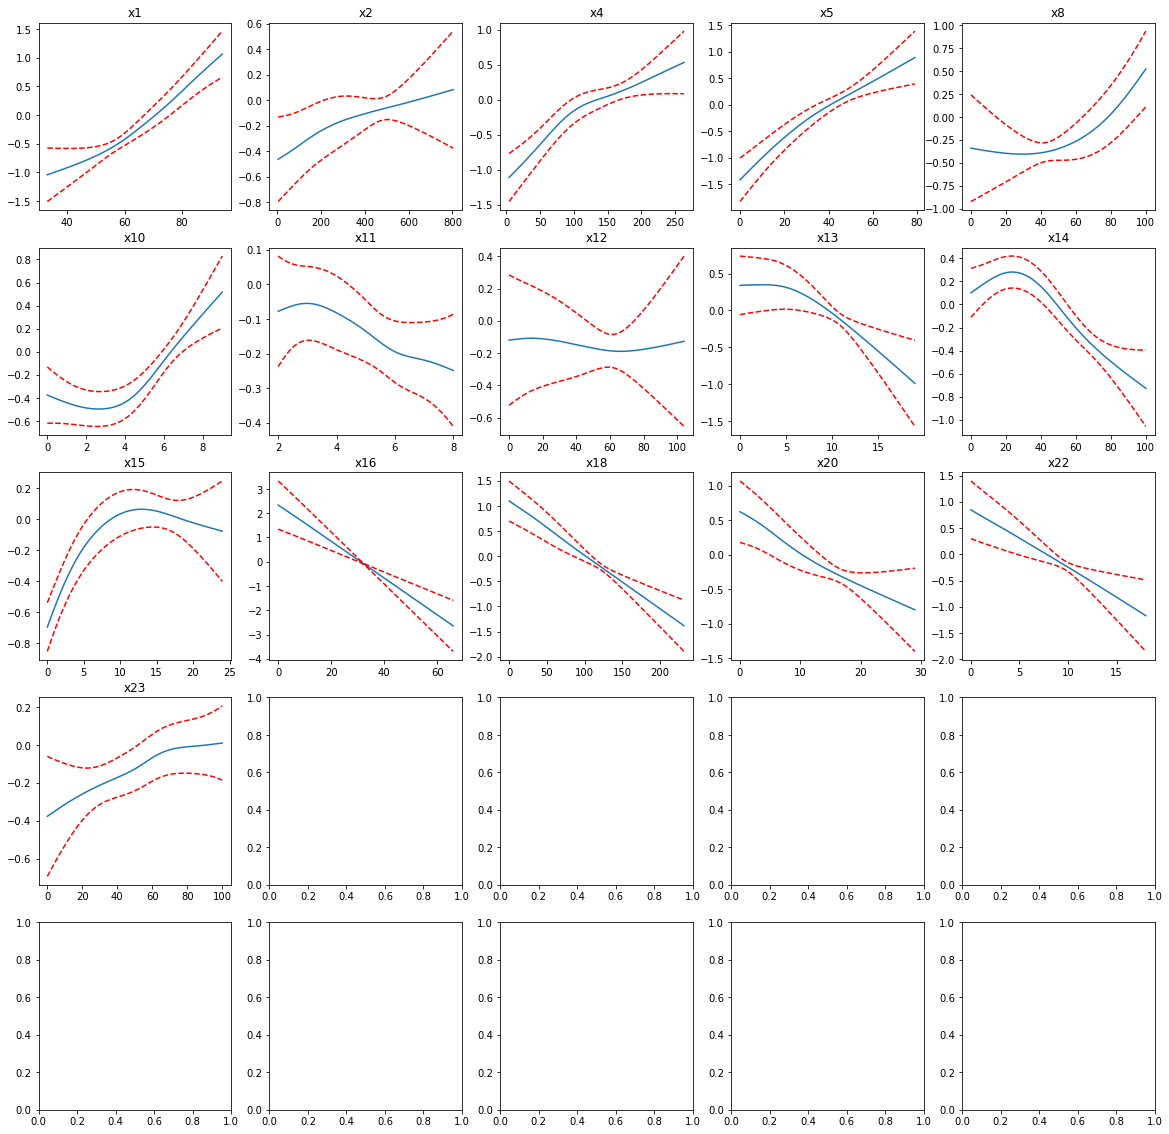

In [393]:
# plotting 
fig, axs = plt.subplots(5,5,figsize=(20,20))
for i, ax in enumerate(axs.flatten()[:23]):
    XX = gam.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(names[i])
plt.tight_layout()


In [394]:
y_pred_train = gam.predict(X_train)
y_pred_test = gam.predict(X_test)

mse = mean_squared_error(y_train,y_pred_train)
print('mse_GAM: ',mse)
print('The Acc on training set:',accuracy_score(y_train,y_pred_train))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test))

mse_GAM:  0.26165146909827763
The Acc on training set: 0.7383485309017224
The Acc on testing set: 0.7387341772151899


In [25]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     33.6933
Link Function:                        LogitLink Log Likelihood:                                  -4231.491
Number of Samples:                         7896 AIC:                                             8530.3687
                                                AICc:                                            8530.6837
                                                UBRE:                                               3.0838
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2256
Feature Function                  Lam

<ipython-input-25-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


#### GAM with monotonicity constraints

In [395]:
constraints = ['monotonic_inc','monotonic_inc','monotonic_inc','monotonic_inc','monotonic_inc','monotonic_inc','monotonic_inc',None,'monotonic_dec',None, 'monotonic_inc','monotonic_dec','monotonic_dec',None,'monotonic_dec',None]
gam_const = LogisticGAM(constraints=constraints).gridsearch(np.array(X_train),y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


In [396]:
gam_const.accuracy(X_train,y_train), gam_const.accuracy(X_test,y_test)

(0.7384751773049646, 0.740253164556962)

ValueError: cannot create grid for intercept term

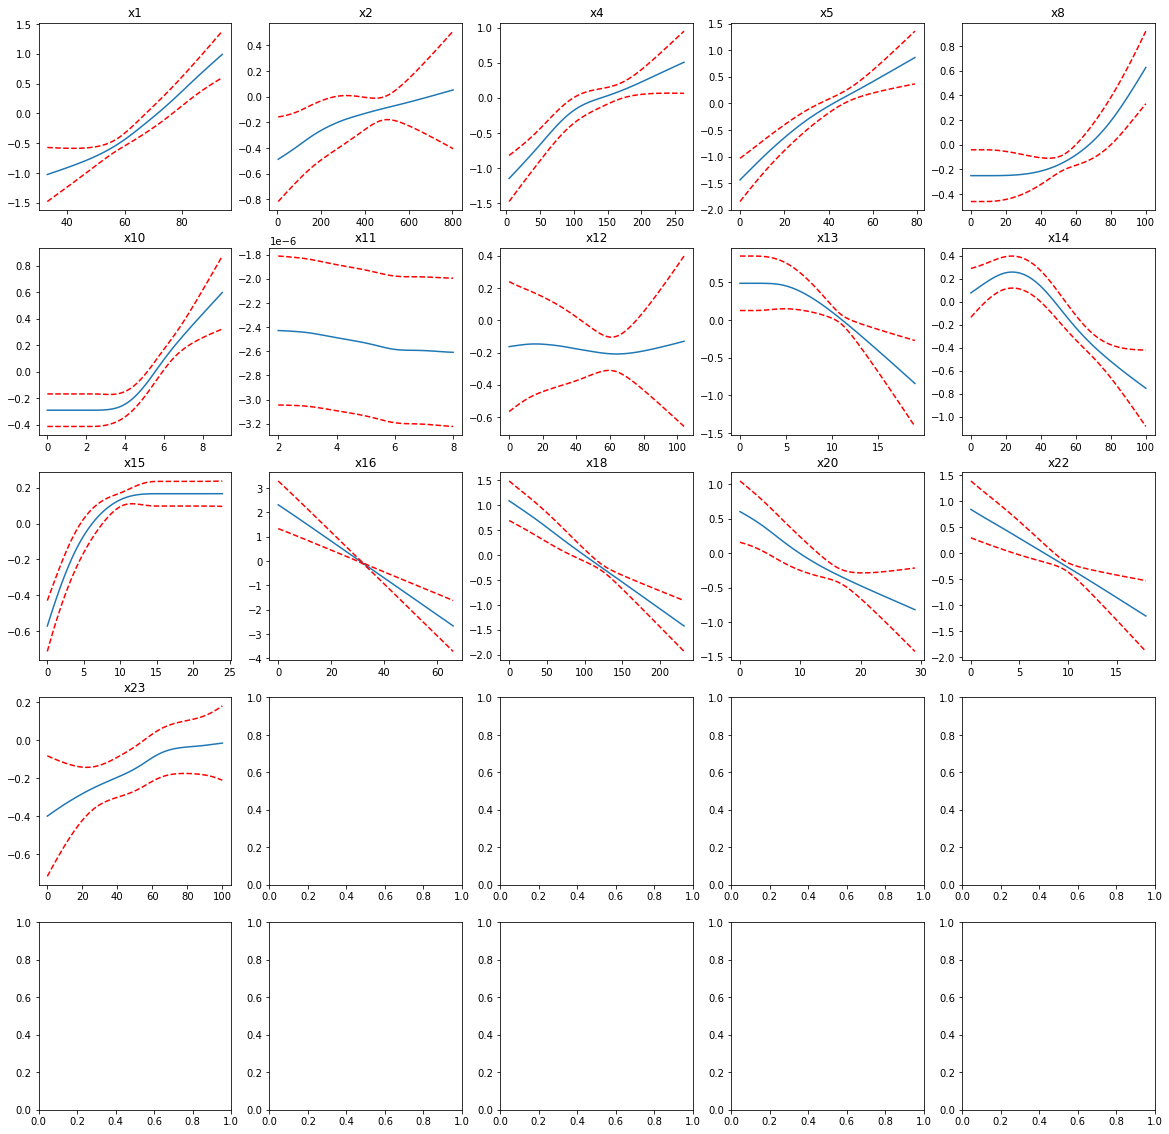

In [397]:
# plotting 
fig, axs = plt.subplots(5,5,figsize=(20,20))
for i, ax in enumerate(axs.flatten()[:23]):
    XX = gam_const.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], gam_const.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam_const.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(names[i])
plt.tight_layout()


In [399]:
gam_const.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     28.8035
Link Function:                        LogitLink Log Likelihood:                                 -4234.3518
Number of Samples:                         7896 AIC:                                             8526.3105
                                                AICc:                                             8526.544
                                                UBRE:                                               3.0827
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2251
Feature Function                  Lam

<ipython-input-399-0d324e0ddb73>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_const.summary()


### SVM

In [518]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [519]:
import matplotlib.colors as col
def plot_decision_boundary(x, y, model, title):
    h = 0.02
    x_min, x_max = x[:, 0].min()-0.1, x[:, 0].max() +0.1
    y_min, y_max = x[:, 1].min()-0.1, x[:, 1].max() +0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    cmap_light = col.ListedColormap(['#AAFFAA','#AAAAFF','#FFAAAA'])
    cmap_bold = col.ListedColormap(['#00FF00','#0000FF','#FF0000'])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(x[:, 0], x[:, 1], c=y, 
                    edgecolor='k',cmap=cmap_bold)
    
    plt.title(title, fontsize = 20)

In [520]:
#hyperparameter optimization

# no tuning
svc = SVC(gamma="scale",kernel='rbf')
svc.fit(np.array(X_train),y_train)
print('SVM training Accuracy:',accuracy_score(y_train,svc.predict(X_train)))
print('SVM test Accuracy:',accuracy_score(y_test,svc.predict(X_test)))

SVM training Accuracy: 0.7302431610942249
SVM test Accuracy: 0.730632911392405


In [521]:
# calculate support vectors percentage
n_sv = svc.support_.shape[0]
percentage = n_sv / X_train.shape[0]
print('Proportion of support vectors used: {:.2%}'.format(percentage))

Proportion of support vectors used: 64.20%


In [522]:
param_grid = [
  {'C': np.logspace(0.1,1,10), 'gamma': np.logspace(-3,3,10)},
 ]
svc = SVC(gamma="scale",kernel='rbf')
clf = GridSearchCV(svc, param_grid, cv=5, verbose=1)
clf.fit(X_train,y_train)
print('Accuracy:',accuracy_score(y_train,clf.predict(X_train)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 33.2min finished


Accuracy: 0.8267477203647416


In [523]:
print('Accuracy:',accuracy_score(y_test,clf.predict(X_test)))

Accuracy: 0.7017721518987342


In [524]:
# in randomized search, we can specify the parameter distribution
import scipy.stats as sps
param_grid = {'C': sps.uniform(loc=1,scale=2), 'gamma': sps.uniform(loc=0.01,scale=20)}
np.random.seed(3612202007)
svc = SVC(gamma="scale")
clf = RandomizedSearchCV(svc, param_grid, cv=5,n_iter=100,verbose=1)
clf.fit(X_train,y_train)
print('Accuracy:',accuracy_score(y_train,clf.predict(X_train)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 39.5min finished


Accuracy: 1.0


In [525]:
clf.best_params_

{'C': 2.1277500415674804, 'gamma': 15.269235186568546}

In [526]:
#! pip install eli5

In [527]:
import eli5
from eli5.sklearn import PermutationImportance

In [529]:
# define a permutation importance object
perm = PermutationImportance(clf).fit(X_train, y_train)
# show the importance
eli5.show_weights(perm, feature_names=np.array(var_names_combined))

Weight,Feature
0.4742 ± 0.0011,x2 - Months Since Oldest Trade Open
0.4716 ± 0.0008,x4 - Average Months in File
0.4675 ± 0.0019,x18 - Net Fraction Revolving Burden
0.4667 ± 0.0011,x14 - Percent Installment Trades
0.4658 ± 0.0011,x12 - Number of Total Trades
0.4633 ± 0.0010,x5 - Number Satisfactory Trades
0.4630 ± 0.0018,x1 - Consolidated version of risk markers
0.4590 ± 0.0012,x23 - Percent Trades with Balance
0.4166 ± 0.0047,x20 - Number Revolving Trades with Balance
0.3824 ± 0.0052,x13 - Number of Trades Open in Last 12 Months


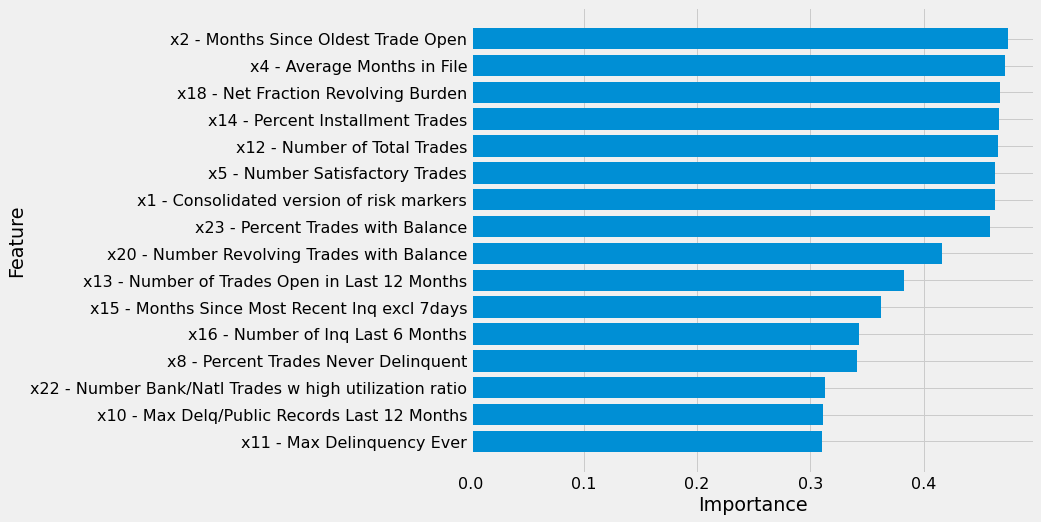

In [531]:
# importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm.feature_importances_))*1
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,var_names_combined[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

### Decision Trees

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

DT_clf = DecisionTreeClassifier()

param_grid = [{'max_depth': np. logspace(0.1,1,30)}]
DT_clf2 = GridSearchCV(DT_clf, param_grid, cv=5, verbose=1)

DT_clf2.fit(X_train, y_train)

print('Training Accuracy:', accuracy_score(y_train, DT_clf2.predict(X_train)).round(4))
print('Testing Accuracy:', accuracy_score(y_test, DT_clf2.predict(X_test)).round(4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training Accuracy: 0.7213
Testing Accuracy: 0.6967


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.2s finished


#### Bagging

In [9]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=100, oob_score=True, random_state=0)
bag_clf.fit(X_train, y_train)

print('Training Accuracy:', accuracy_score(y_train, bag_clf.predict(X_train)).round(4))
print('OOB Accuracy:', bag_clf.oob_score_.round(4))

print('Testing Accuracy:', accuracy_score(y_test, bag_clf.predict(X_test)).round(4))

Training Accuracy: 1.0
OOB Accuracy: 0.713
Testing Accuracy: 0.7246


### Random Forest

In [400]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import uniform, truncnorm, randint

RF_clf = RandomForestClassifier(n_estimators=100, 
                               random_state=50, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1,
                               oob_score=True)


param_dist = {'n_estimators': stats.randint(10, 1000),
              'max_depth': [3, 4, 5, 6, 7, 8, 9,10],
              'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
              'min_samples_split': uniform(0.01, 0.199),
             }

RF_clf_grid = RandomizedSearchCV(RF_clf,
                              param_distributions=param_dist,
                              cv=5,
                              n_jobs=-2,
                              verbose=2,
                              n_iter=20,
                              random_state=1)


RF_clf_grid = RF_clf_grid.fit(X_train,y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 605 out of 605 | elapsed:    1.4s finished


In [401]:
print("Training Accuracy:", accuracy_score(y_train, RF_clf_grid.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, RF_clf_grid.predict(X_test)))

RF_params = RF_clf_grid.best_params_
RF_params

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 605 out of 605 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Training Accuracy: 0.7575987841945289
Test Accuracy: 0.7346835443037975


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 605 out of 605 | elapsed:    0.1s finished


{'max_depth': 8,
 'max_features': array([0.26114861]),
 'min_samples_split': 0.013854024616189118,
 'n_estimators': 605}

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 605 out of 605 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 605 out of 605 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 605 out of 605 | elapsed:    0.1s finished
[

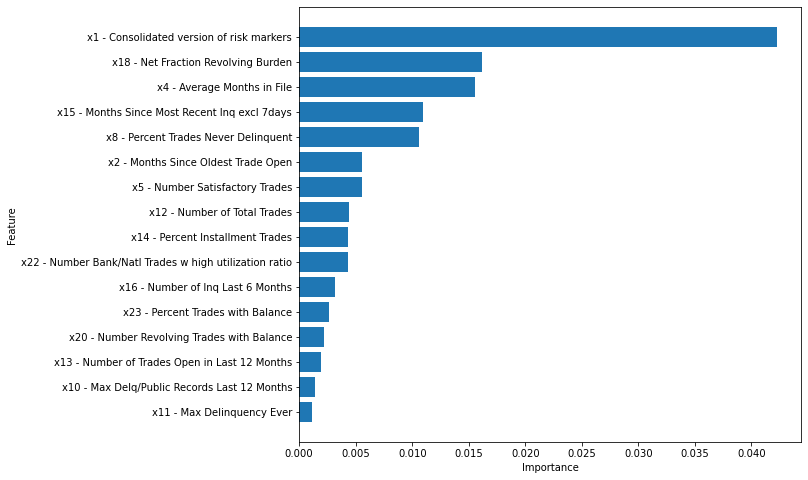

In [404]:
var_names_combined = var_names[names].index+" - "+var_names[names].values

# define a permutation importance object
perm_rf = PermutationImportance(RF_clf_grid).fit(X_train, y_train)
# show the importance
eli5.show_weights(perm_rf, feature_names=np.array(var_names_combined))

# importance in decreasing order
imp_ord = np.argsort(perm_rf.feature_importances_)

plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm_rf.feature_importances_))*1
plt.barh(y = yaxis,width = perm_rf.feature_importances_[imp_ord])
plt.yticks(yaxis,var_names_combined[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

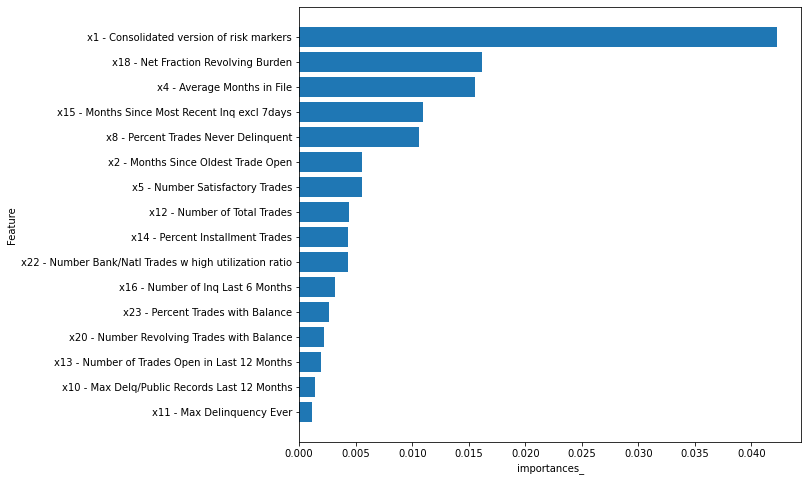

In [406]:
# importances_ortance in decreasing order
importances__ord = np.argsort(perm_rf.feature_importances_)

plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm_rf.feature_importances_))*1
plt.barh(y = yaxis,width = perm_rf.feature_importances_[importances__ord])
plt.yticks(yaxis,var_names_combined[importances__ord])
plt.ylabel('Feature')
plt.xlabel('importances_')
plt.show()

### Neural Network

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [12]:
#conda install graphviz

#### Model 1: 2 hidden layers with 20 nodes each

In [14]:
# sequentially define the model
model = Sequential()
# first hidden layer with 10 nodes
model.add(Dense(20, activation='relu', input_dim=X_train.columns.shape[0]))
# second hidden layer with 10 nodes
model.add(Dense(20, activation='relu'))
# output layer
model.add(Dense(1, activation='sigmoid'))

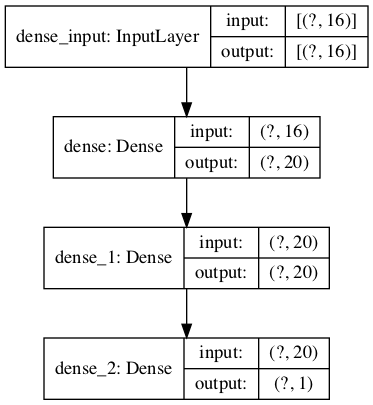

In [15]:
# visualize the model
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True)

In [16]:
# compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [17]:
# train the model
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    epochs=300, batch_size=256,verbose=0)
score = model.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %0.4f'%score[1])
score = model.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Training accuracy: 0.7147
Testing accuracy: 0.7078


#### Model 2: 2 hidden layers with 100 nodes each

In [19]:
# sequentially define the model
model2 = Sequential()
# first hidden layer with 100 nodes
model2.add(Dense(100, activation='relu', input_dim=X_train.columns.shape[0]))
# second hidden layer with 100 nodes
model2.add(Dense(100, activation='relu'))
# output layer
model2.add(Dense(1, activation='sigmoid'))

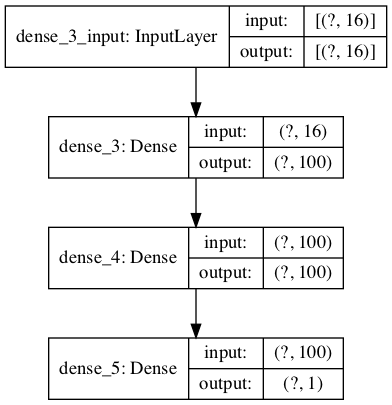

In [20]:
# visualize the model
from tensorflow.keras.utils import plot_model
plot_model(model2,show_shapes=True, show_layer_names=True)

In [21]:
# compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [22]:
# train the model
history = model2.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    epochs=300, batch_size=256,verbose=0)
score = model2.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %0.4f'%score[1])
score = model2.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Training accuracy: 0.7475
Testing accuracy: 0.7144


#### Model 3: 1 hidden layer with 20 nodes

In [24]:
# sequentially define the model
model3 = Sequential()
# first hidden layer with 20 nodes
model3.add(Dense(20, activation='relu', input_dim=X_train.columns.shape[0]))
# output layer
model3.add(Dense(1, activation='sigmoid'))

In [25]:
# compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
model3.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [26]:
# train the model(1 layer with 20 nodes)
history = model3.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    epochs=300, batch_size=256,verbose=0)
score = model3.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %0.4f'%score[1])
score = model3.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Training accuracy: 0.7169
Testing accuracy: 0.7038


#### Model 4: 1 hidden layer with 50 nodes

In [27]:
# different model (model 4: 1 layer with 50 nodes)
# sequentially define the model
model4 = Sequential()
# first hidden layer with 50 nodes
model4.add(Dense(50, activation='relu', input_dim=X_train.columns.shape[0]))
# output layer
model4.add(Dense(1, activation='sigmoid'))

In [28]:
# compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
model4.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [29]:
# train the model(1 layers with 50 nodes)
history = model4.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    epochs=300, batch_size=256,verbose=0)
score = model4.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %0.4f'%score[1])
score = model4.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Training accuracy: 0.7153
Testing accuracy: 0.7023


#### Model 5: 3 hidden layers with 20 nodes each

In [30]:
# sequentially define the model
model5 = Sequential()
# first hidden layer with 20 nodes
model5.add(Dense(20, activation='relu', input_dim=X_train.columns.shape[0]))
# second hidden layer with 20 nodes
model5.add(Dense(20, activation='relu'))
# third hidden layer with 20 nodes
model5.add(Dense(20, activation='relu'))
# output layer
model5.add(Dense(1, activation='sigmoid'))

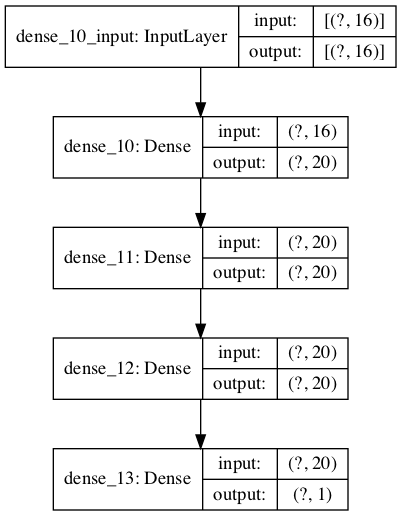

In [31]:
# visualize the model
from tensorflow.keras.utils import plot_model
plot_model(model5,show_shapes=True, show_layer_names=True)

In [32]:
# compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
model5.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [33]:
# train the model(1 layers with 50 nodes)
history = model5.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    epochs=300, batch_size=256,verbose=0)
score = model5.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %0.4f'%score[1])
score = model5.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Training accuracy: 0.7256
Testing accuracy: 0.7018


#### Model 6: 2 hidden layers with 50 nodes each

In [35]:
# sequentially define the model
model6 = Sequential()
# first hidden layer with 50 nodes
model6.add(Dense(50, activation='relu', input_dim=X_train.columns.shape[0]))
# second hidden layer with 50 nodes
model6.add(Dense(50, activation='relu'))
# output layer
model6.add(Dense(1, activation='sigmoid'))

In [36]:
# compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
model6.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [37]:
# train the model(1 layers with 50 nodes)
history = model6.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    epochs=300, batch_size=256,verbose=0)
score = model6.evaluate(X_train, y_train, verbose=0)
print('Training accuracy: %0.4f'%score[1])
score = model6.evaluate(X_test, y_test, verbose=0)
print('Testing accuracy: %0.4f'%score[1])

Training accuracy: 0.7310
Testing accuracy: 0.7018


#### Plot training & testing accuracy values (Model 1)

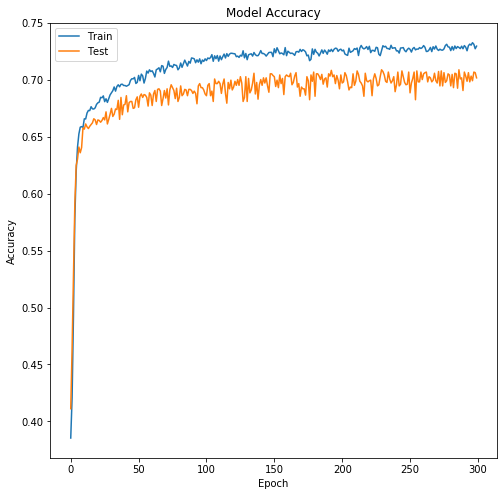

In [38]:
plt.figure(figsize=(8,8))
try:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
except:
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

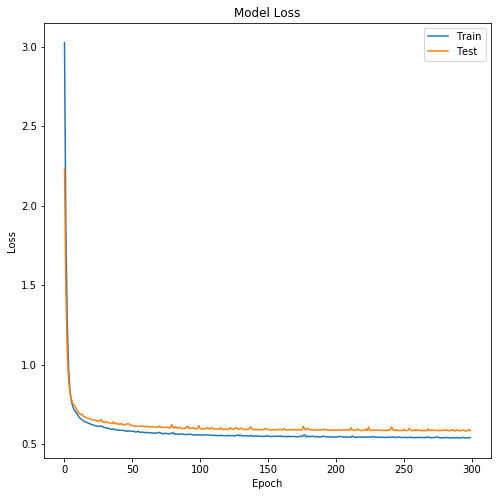

In [39]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

### XGBoost 

In [409]:
# !pip install xgboost
import xgboost as xgb

In [410]:
# specify parameters via map
dtrain = xgb.DMatrix(data=X_train,
                     feature_names=np.array(names),
                     label=y_train)

dtest = xgb.DMatrix(data=X_test,
                     feature_names=np.array(names),
                     label=y_test)

params = {'max_depth':10,'alpha':10,'n_estimators':10, 'eta':0.1, 'colsample_bytree' : 0.3,'objective':'binary:logistic'}
xgb_noconst = xgb.train(params=params, dtrain=dtrain, num_boost_round = 1000, evals = [(dtest,'test'), (dtrain,'train')], early_stopping_rounds = 100,verbose_eval=20)

print("Best score: ",xgb_noconst.best_score)
print("Training accuracy without constraints: ", accuracy_score(y_train, xgb_noconst.predict(dtrain).round()))
print("Test accuracy without constraints: ", accuracy_score(y_test, xgb_noconst.predict(dtest).round()))

[11:00:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-error:0.31949	train-error:0.32042
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 100 rounds.
[20]	test-error:0.26683	train-error:0.25063
[40]	test-error:0.26734	train-error:0.24455
[60]	test-error:0.26430	train-error:0.23746
[80]	test-error:0.26785	train-error:0.23138
[100]	test-error:0.26987	train-error:0.22632
[120]	test-error:0.27190	train-error:0.21505
[140]	test-error:0.27241	train-error:0.21087
[160]	test-error:0.27443	train-error:0.20681
[180]	test-error:0.27696	train-error:0.20086
[200]	test-error:0

In [411]:
xgb_scikit = xgb.XGBClassifier(verbose=0,
                               objective='binary:logistic',
                               n_jobs=-2)

param_dist = {'n_estimators': stats.randint(10, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9,10],
              'colsample_bytree': stats.uniform(0.3, 0.9),
              'min_child_weight': [1, 2, 3, 4],
              'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
             }


xgb_grid = RandomizedSearchCV(xgb_scikit,
                              param_distributions=param_dist,
                              cv=5,
                              n_jobs=-2,
                              verbose=1,
                              n_iter=20)
xgb_grid.fit(X_train, y_train)


print("XGBoost Training mse:", mean_squared_error(y_train, xgb_grid.predict(X_train).round()))
print("XGBoost Testing mse:", mean_squared_error(y_test, xgb_grid.predict(X_test).round()))
print("XGBoost Training accuracy:", accuracy_score(y_train, xgb_grid.predict(X_train).round()))
print("XGBoost Testing accuracy:", accuracy_score(y_test, xgb_grid.predict(X_test).round()))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   33.7s finished


[11:00:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Training mse: 0.22922998986828774
XGBoost Testing mse: 0.2724050632911392
XGBoost Training accuracy: 0.7707700101317123
XGBoost Testing accuracy: 0.7275949367088608


In [412]:
xgb_grid.best_params_

{'colsample_bytree': 0.4282399071602524,
 'learning_rate': 0.16104101715299204,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 147,
 'reg_alpha': 0,
 'subsample': 0.9714440882623232}

### XGBoost with monotonic constraints

In [413]:
params_constrained = {'max_depth': 4,
 'min_child_weight': 4,
 'n_estimators': 626,
 'eta': 0.016415801394954126,
 'colsample_bytree': 0.5387513382801395,
 'objective': 'binary:logistic',
 'subsample': 0.6232243845880807,
 'reg_alpha': 0.001,
 'monotone_constraints': '(1,1,1,1,1,1,1,0,-1,0,1,-1,-1,0,-1,0)'}

In [414]:
model_with_constraints = xgb.train(params=params_constrained, 
                                   dtrain=dtrain, 
                                   num_boost_round = 1000, 
                                   evals = [(dtest,'test'), (dtrain,'train')], 
                                   early_stopping_rounds = 100,verbose_eval=20)


[11:01:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-error:0.28203	train-error:0.28977
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 100 rounds.
[20]	test-error:0.27038	train-error:0.26988
[40]	test-error:0.26987	train-error:0.27077
[60]	test-error:0.26835	train-error:0.26811
[80]	test-error:0.26785	train-error:0.26824
[100]	test-error:0.26582	train-error:0.26735
[120]	test-error:0.26430	train-error:0.26583
[140]	test-error:0.26633	train-error:0.26418
[160]	test-error:0.26582	train-error:0.26355
[180]	test-error:0.26785	train-error:0.26127
[200]	test-error:0

In [415]:
print('Best training score: ',model_with_constraints.best_score)
print("Training accuracy with constraints: ", accuracy_score(y_train, model_with_constraints.predict(dtrain).round()))
print("Test accuracy with constraints: ", accuracy_score(y_test, model_with_constraints.predict(dtest).round()))

Best training score:  0.238982
Training accuracy with constraints:  0.7603850050658562
Test accuracy with constraints:  0.7346835443037975


### LightGBM

In [416]:
# !pip install lightgbm

In [492]:
import lightgbm 
from lightgbm import LGBMClassifier
LGBM = LGBMClassifier(n_estimators = 99,
                       learning_rate=0.075171,
                       num_leaves=10,
                       subsample=0.563710,
                       subsample_freq=1,
                       colsample_bytree=0.363497,
                       random_state = 37,
                     verbose=0,
                     force_col_wise=True)

LGBM_param_dist = {'n_estimators': stats.randint(10, 500),
              'learning_rate': stats.uniform(0.01, 0.3),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9,10],
              'colsample_bytree': stats.uniform(0.3, 0.9),
              'min_child_weight': [1, 2, 3, 4, 5],
              'num_leaves': [4,5,6,7,8,9] }

LGBM_grid = RandomizedSearchCV(LGBM,
                              param_distributions=LGBM_param_dist,
                              cv=5,
                              verbose=-1,
                              n_jobs=-2,
                              n_iter=20)

LGBM_grid.fit(X_train, y_train)

print("LGBM Training mse:", mean_squared_error(y_train, LGBM_grid.predict(X_train).round()))
print("LGBM Testing mse:", mean_squared_error(y_test, LGBM_grid.predict(X_test).round()))
print("LGBM Training accuracy:", accuracy_score(y_train, LGBM_grid.predict(X_train).round()))
print("LGBM Testing accuracy:", accuracy_score(y_test, LGBM_grid.predict(X_test).round()))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.5s


LGBM Training mse: 0.2540526849037487
LGBM Testing mse: 0.25721518987341774
LGBM Training accuracy: 0.7459473150962512
LGBM Testing accuracy: 0.7427848101265823


[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    2.1s finished


In [493]:
LGBM_grid.best_params_

{'colsample_bytree': 0.31245576980888967,
 'learning_rate': 0.03125094707840759,
 'max_depth': 8,
 'min_child_weight': 5,
 'n_estimators': 132,
 'num_leaves': 9,
 'subsample': 0.3083134162521744}

### LGBM with monotonic constraints 

In [494]:
LGBM_constraints =  LGBMClassifier(max_depth= 8,
                           alpha= 10,
                           n_estimators=132,
                           colsample_bytree= 0.31245576980888967,
                           min_child_weight= 5,
                           subsample= 0.3083134162521744,
                       learning_rate=0.03125094707840759,
                       num_leaves=9,
                       subsample_freq=3,
                       random_state = 3612202007,
                       verbose=-1,
                       force_col_wise=True,
                       monotone_constraints= '(1,1,1,1,1,1,1,0,-1,0,1,-1,-1,0,-1,0)')


LGBM_constraints.fit(X_train, y_train)
print("LGBM_constraint Training accuracy:", accuracy_score(y_train, LGBM_constraints.predict(X_train).round()))
print("LGBM_constraint Testing accuracy:", accuracy_score(y_test, LGBM_constraints.predict(X_test).round()))

LGBM_constraint Training accuracy: 0.7405015197568389
LGBM_constraint Testing accuracy: 0.7407594936708861


In [495]:
# define a permutation importance object
perm_lgbm = PermutationImportance(LGBM_constraints).fit(X_train, y_train)
# show the importance
eli5.show_weights(perm_lgbm, feature_names=np.array(var_names_combined))


Weight,Feature
0.0405 ± 0.0037,x1 - Consolidated version of risk markers
0.0087 ± 0.0009,x4 - Average Months in File
0.0085 ± 0.0030,x15 - Months Since Most Recent Inq excl 7days
0.0041 ± 0.0034,x8 - Percent Trades Never Delinquent
0.0040 ± 0.0041,x5 - Number Satisfactory Trades
0.0039 ± 0.0026,x18 - Net Fraction Revolving Burden
0.0033 ± 0.0026,x10 - Max Delq/Public Records Last 12 Months
0.0023 ± 0.0010,x12 - Number of Total Trades
0.0022 ± 0.0025,x22 - Number Bank/Natl Trades w high utilization ratio
0.0013 ± 0.0017,x16 - Number of Inq Last 6 Months


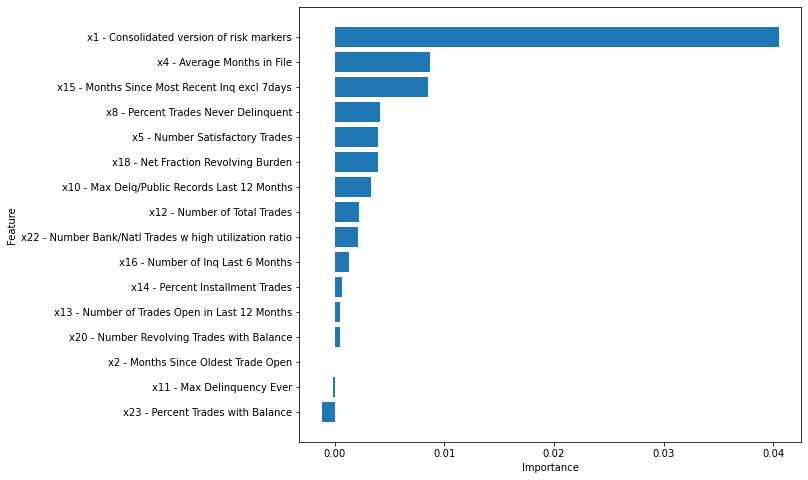

In [496]:
# importance in decreasing order
imp_ord = np.argsort(perm_lgbm.feature_importances_)

plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm_lgbm.feature_importances_))*1
plt.barh(y = yaxis,width = perm_lgbm.feature_importances_[imp_ord])
plt.yticks(yaxis,var_names_combined[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

### Post-hoc interpretation on LightGBM 

In [429]:
%time !pip install eli5
%time !pip install shap
%time !pip install lime

Wall time: 2.66 s
Wall time: 2.17 s



In [431]:
feature_dic=pd.read_excel("./HelocDataDict.xlsx",index_col = 'Variable Names')
feature_dic['Description']=feature_dic['Description'][names].astype(str)
feature_dic=pd.DataFrame({'Description':feature_dic['Description'][names].astype(str)})
print(feature_dic)

                                                      Description
Variable Names                                                   
x1                           Consolidated version of risk markers
x2                                 Months Since Oldest Trade Open
x4                                         Average Months in File
x5                                     Number Satisfactory Trades
x8                                Percent Trades Never Delinquent
x10             Max Delq/Public Records Last 12 Months. See ta...
x11             Max Delinquency Ever. See tab "MaxDelq" for ea...
x12             Number of Total Trades (total number of credit...
x13                       Number of Trades Open in Last 12 Months
x14                                    Percent Installment Trades
x15                       Months Since Most Recent Inq excl 7days
x16                                   Number of Inq Last 6 Months
x18             Net Fraction Revolving Burden. This is revolvi...
x20       

In [432]:
#feature_names=pd.df(feature_names)
var_names=[]
for i in range(len(feature_dic)):
    var_names.append(feature_dic.index[i]+'-' + feature_dic.Description[i])
var_names

['x1-Consolidated version of risk markers',
 'x2-Months Since Oldest Trade Open',
 'x4-Average Months in File',
 'x5-Number Satisfactory Trades',
 'x8-Percent Trades Never Delinquent',
 'x10-Max Delq/Public Records Last 12 Months. See tab "MaxDelq" for each category',
 'x11-Max Delinquency Ever. See tab "MaxDelq" for each category',
 'x12-Number of Total Trades (total number of credit accounts)',
 'x13-Number of Trades Open in Last 12 Months',
 'x14-Percent Installment Trades',
 'x15-Months Since Most Recent Inq excl 7days',
 'x16-Number of Inq Last 6 Months',
 'x18-Net Fraction Revolving Burden. This is revolving balance divided by credit limit',
 'x20-Number Revolving Trades with Balance',
 'x22-Number Bank/Natl Trades w high utilization ratio',
 'x23-Percent Trades with Balance']

In [433]:
from scipy import stats 
from sklearn.model_selection import RandomizedSearchCV

In [497]:
import shap

# load JS visualization code
shap.initjs()

# kernel explainer is slow so we use shap.kmeans(data,K) to accelerate its evaluation
# we set K=5 for fast illustration, larger value should be considered in the real case
# explainer should be defined on the training set
explainer = shap.KernelExplainer(LGBM_constraints.predict_proba, shap.kmeans(X_train, 5))

n_explain = 200
# explain on the training set (first 200 samples)
shap_values = explainer.shap_values(X_train[:n_explain])

# explain on the testing set
# shap_values = explainer.shap_values(X_test)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it wi

In [498]:
explainer.expected_value

array([0.48480649, 0.51519351])

In [499]:
# '1' in explainer.expected_value[1]: we consider the feature effects of P(Y=1)
# shap_values[1][i]: extract the shape value of the ith sample that correponds to P(Y=1)
# X_train[i]: the ith sample in training set

#i = 1
#shap.force_plot(base_value=explainer.expected_value[1], shap_values=shap_values[1][i],features=X_train[i], feature_names=feature_names)

#shap.initjs() #initialize javascript in cell
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:], var_names)

In [500]:
shap.force_plot(explainer.expected_value[1], shap_values[1],
                X_train[:n_explain], feature_names=var_names)

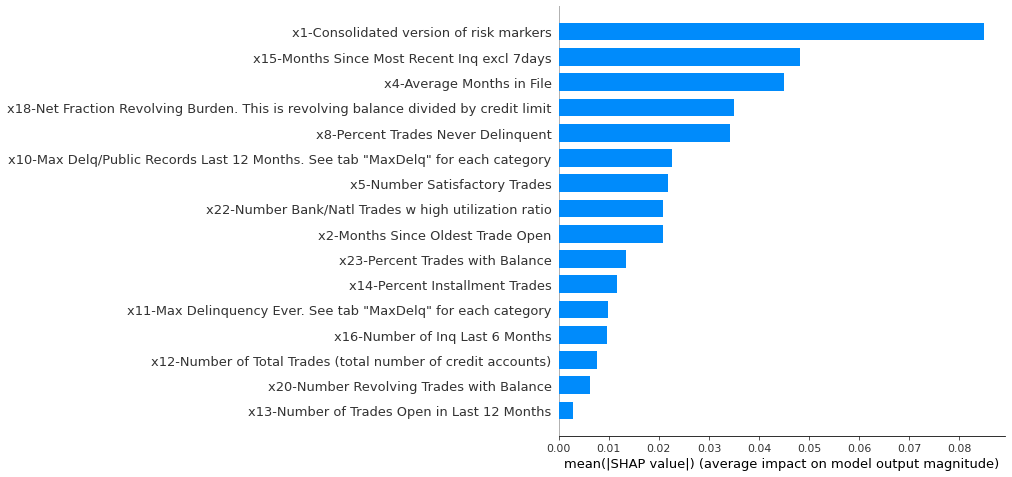

In [501]:
shap.summary_plot(shap_values[1], feature_names=var_names, plot_type='bar')

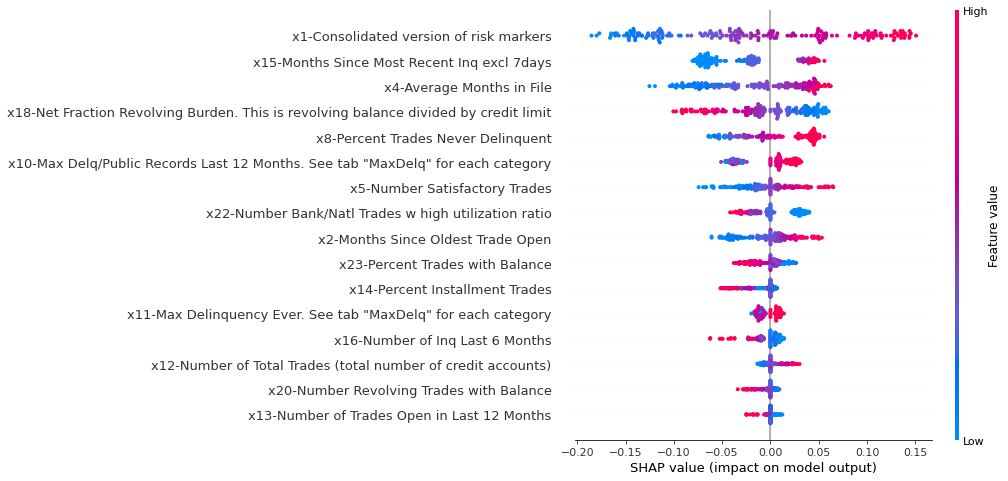

In [502]:
shap.summary_plot(shap_values[1], X_train[:n_explain],
                  feature_names=var_names)


##### Lime

In [503]:
np.random.seed(3612202007)
i = np.random.randint(0, df_test.shape[0])

pred_i = LGBM_constraints.predict_proba(df_test.iloc[[i], [1,2,4,5,8,10,11,12,13,14,15,16,18,20,22,23]])
print('Predicted probability of Good: {:.2%}'.format(pred_i[0, 1]))
df_test.iloc[[i], [0,1,2,4,5,8,10,11,12,13,14,15,16,18,20,22,23]]

Predicted probability of Good: 83.73%


,RiskFlag,x1,x2,x4,x5,x8,x10,x11,x12,x13,x14,x15,x16,x18,x20,x22,x23
6365,Bad,87.0,228.0,77.0,30.0,100.0,7.0,8.0,31.0,3.0,10.0,2.465163,4.0,6.0,7.0,0.0,38.0


Intercept 0.38120225713656153
Prediction_local [0.58044761]
Right: 0.5211299503611723


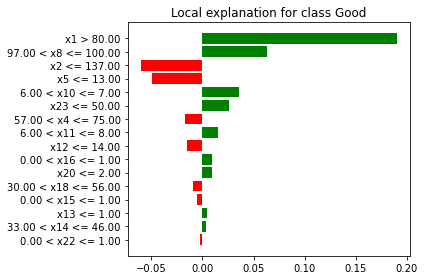

In [504]:
 from lime.lime_tabular import LimeTabularExplainer

# step2:
# To simulate new data points, fit an explainer with data from trainning set
    #categorical_idx = [0] + list(range(6, 18))  # get categorical feature names
class_names = ['Bad','Good']
explainer = LimeTabularExplainer(
    X_train.values, feature_names=names,class_names=class_names,mode="classification",
                                                       verbose=True)

    # step3: train a interpretable model
    # by default LIME use ridge regression
exp = explainer.explain_instance(
    X_test.values[0,:], predict_fn= LGBM_constraints.predict_proba, num_features=23)

    # visualize the result
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

#### Local Interpretation

In [505]:
# LIME
from interpret.blackbox import LimeTabular
from interpret import show

# LIME explainers
# feature_names should be transferred into list type in IML
lime = LimeTabular(predict_fn=LGBM_constraints.predict_proba, data=X_train,
                   random_state=1, feature_names=names)

# local explaination on instances
lime_local = lime.explain_local(X_train[:5], y_train[:5], name='LIME')

# visualization
show(lime_local)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


<!-- http://127.0.0.1:7001/2375977171312/ -->

In [506]:
# SHAP

from interpret.blackbox import ShapKernel

# define the shap explainer
background_val = np.median(X_train, axis=0).reshape(1, -1)
shap = ShapKernel(predict_fn=LGBM_constraints.predict_proba,
                  data=background_val, feature_names=names)
shap_local = shap.explain_local(X_train[:5], y_train[:5], name='SHAP')

show(shap_local)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


<!-- http://127.0.0.1:7001/2375983043776/ -->

In [507]:
from interpret.blackbox import PartialDependence

# partial dependence plot
pdp = PartialDependence(predict_fn=LGBM_constraints.predict_proba,
                        data=X_train, feature_names=var_names)
pdp_global = pdp.explain_global(name='Partial Dependence')

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


In [508]:
show(pdp_global)

<!-- http://127.0.0.1:7001/2375995030976/ -->

In [509]:
LGBM_constraints.get_params

<bound method LGBMModel.get_params of LGBMClassifier(alpha=10, colsample_bytree=0.31245576980888967,
               force_col_wise=True, learning_rate=0.03125094707840759,
               max_depth=8, min_child_weight=5,
               monotone_constraints='(1,1,1,1,1,1,1,0,-1,0,1,-1,-1,0,-1,0)',
               n_estimators=132, num_leaves=9, random_state=3612202007,
               subsample=0.3083134162521744, subsample_freq=3, verbose=-1)>

In [510]:
import eli5
from eli5.sklearn import PermutationImportance

In [511]:
# define a permutation importance object
perm_lgbm = PermutationImportance(LGBM_constraints).fit(X_train, y_train)
# show the importance
eli5.show_weights(perm_lgbm, feature_names=np.array(var_names_combined))


Weight,Feature
0.0406 ± 0.0042,x1 - Consolidated version of risk markers
0.0078 ± 0.0032,x15 - Months Since Most Recent Inq excl 7days
0.0069 ± 0.0042,x4 - Average Months in File
0.0067 ± 0.0010,x18 - Net Fraction Revolving Burden
0.0043 ± 0.0021,x5 - Number Satisfactory Trades
0.0031 ± 0.0033,x8 - Percent Trades Never Delinquent
0.0026 ± 0.0017,x22 - Number Bank/Natl Trades w high utilization ratio
0.0014 ± 0.0009,x12 - Number of Total Trades
0.0013 ± 0.0019,x16 - Number of Inq Last 6 Months
0.0009 ± 0.0021,x10 - Max Delq/Public Records Last 12 Months


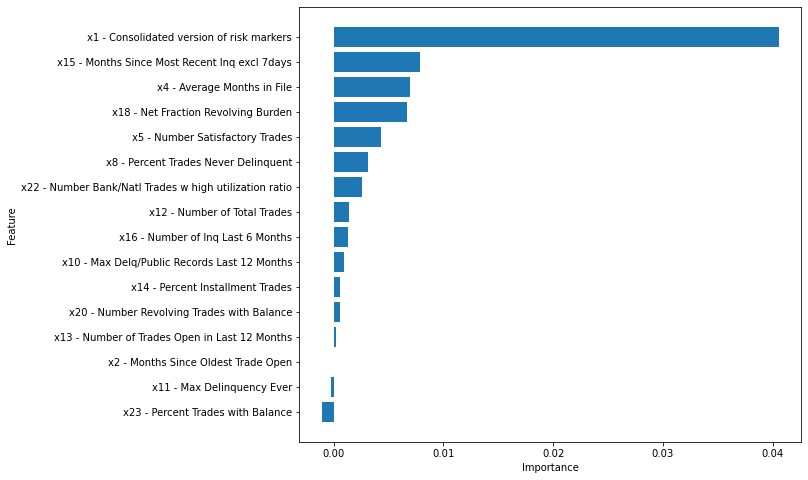

In [512]:
import matplotlib.pyplot as plt
# importance in decreasing order
imp_ord = np.argsort(perm_lgbm.feature_importances_)

plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm_lgbm.feature_importances_))*1
plt.barh(y = yaxis,width = perm_lgbm.feature_importances_[imp_ord])
plt.yticks(yaxis,var_names_combined[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

Recall Baseline: 1.0 Test: 0.71 Train: 0.7
Precision Baseline: 0.49 Test: 0.75 Train: 0.74
Roc Baseline: 0.5 Test: 0.8 Train: 0.81


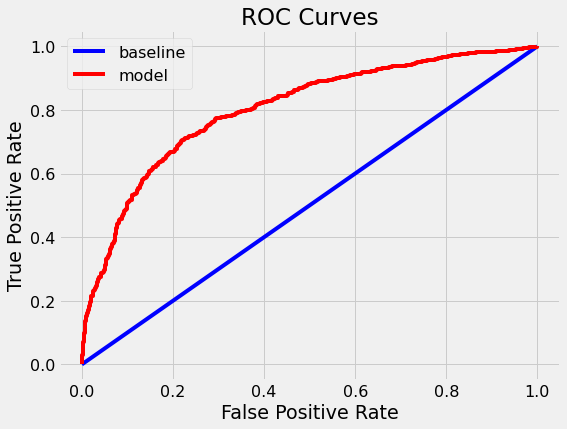

Confusion matrix, without normalization
[[768 231]
 [281 695]]


<Figure size 432x288 with 0 Axes>

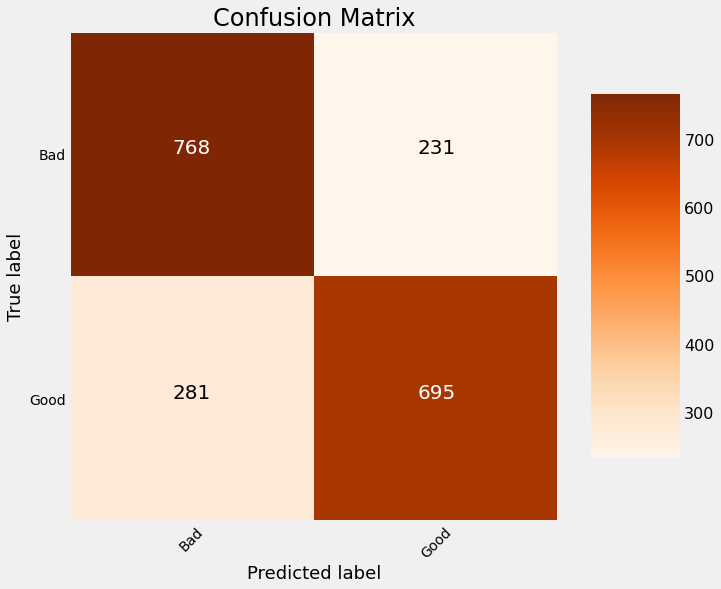

In [517]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Training predictions (to demonstrate overfitting)
train_lgbm_predictions = LGBM_constraints.predict(X_train)
train_lgbm_probs = LGBM_constraints.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
lgbm_predictions = LGBM_constraints.predict(X_test)
lgbm_probs = LGBM_constraints.predict_proba(X_test)[:, 1]

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(lgbm_predictions, lgbm_probs, train_lgbm_predictions, train_lgbm_probs)
plt.savefig('roc_auc_curve.png')

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, lgbm_predictions)
plot_confusion_matrix(cm, classes = ['Bad', 'Good'],
                      title = 'Confusion Matrix')

plt.savefig('cm.png')